# Fitting a line to the data

Obviously the very first exercise is to fit a line to the data. I have already generated the synthetic data elsewhere. In this notebook, I will fit a simple line function, $y = mx + c$ to that dataset using `pymc3`.

This notebook is heavily based on a similar notebook in `exoplanet` docs: https://docs.exoplanet.codes/en/latest/tutorials/intro-to-pymc3/.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import pymc3_ext as pmx
import arviz as az
import corner
import pickle
import os

Let's first load and visualise the data:

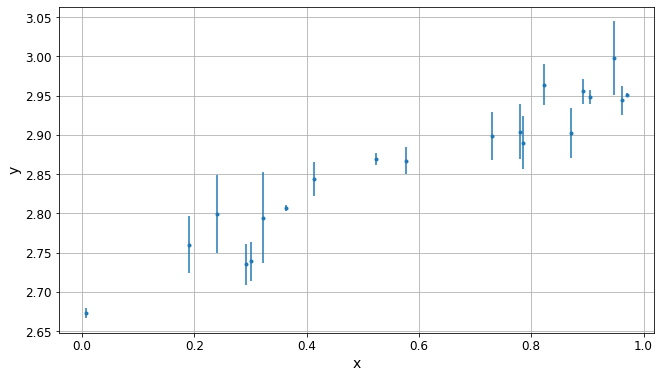

In [2]:
p1 = '/'.join(os.getcwd().split('/')[:-1])
x, y, ye = np.loadtxt(p1 + '/Data/line.dat', usecols=(0,1,2), unpack=True)

fig, axs = plt.subplots(figsize=(16/1.5, 9/1.5))
axs.errorbar(x, y, yerr=ye, fmt='.')
axs.set_xlabel('x', fontsize=14)
axs.set_ylabel('y', fontsize=14)
plt.setp(axs.get_xticklabels(), fontsize=12)
plt.setp(axs.get_yticklabels(), fontsize=12)
plt.grid()

Okay, so this is our data: a typical data with x (which could be time in case of astronomical timeseries), y (flux obs. for instance) and errors on y. Our job is to fit a line to this data. The model of line is simple:

$$ y = mx + c$$

We can first write the (log) likelihood function for this data:

$$log~\mathcal{L}~=~-\frac{1}{2}\sum_{i=1}^{N}\left[\frac{(y_i - mx_i - c)^2}{\sigma^2} + \log{2\pi\sigma^2}\right]$$

Here, $mx_i + c$ is model prediction for $x_i$ th point. I am going to do a slightly different thing than `exoplanet` docs. In that docs they fit also for data uncertainty. However, here we already have an uncertainty estimate on the data -- which could be underestimated though. So, we will add a jitter term in quadrature to the measured errors, i.e., $\sigma$ in above equation could be defined as,

$$\sigma_i = \sqrt{yerr_i^2 + \sigma_w^2}$$

Okay, so, now let's build the model!

In [3]:
with pm.Model() as model:
    # Priors on the model parameters
    m = pm.Uniform('m', lower=0., upper=1., testval=0.2)
    c = pm.Uniform('c', lower=1., upper=5., testval=2.)
    log_sigw = pm.Uniform('logs', lower=-5, upper=5, testval=-4)
    # Let's also track the value of line for each iteration
    pm.Deterministic('y', m*x + c)
    # And the likelihood function,
    pm.Normal('obs', mu=m*x + c, sd=pm.math.sqrt(pm.math.sqr(ye)+ pm.math.sqr(pm.math.exp(log_sigw))), observed=y)
    # Optimizing it first
    opt_soln = pmx.optimize(start=model.test_point)

with model:
    trace = pmx.sample(
        tune=3000,
        draws=3000,
        start=opt_soln,
        cores=2,
        chains=2,
        target_accept=0.9,
        return_inferencedata=True,
    )

pickle.dump(trace, open(p1 + '/Line/Analysis/res_pymc3.pkl','wb'))

optimizing logp for variables: [logs, c, m]


message: Optimization terminated successfully.
logp: -7388.264556881772 -> 38.94558421944862
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logs, c, m]


/Users/japa6985/opt/anaconda3/envs/exo/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/japa6985/opt/anaconda3/envs/exo/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 3_000 tune and 3_000 draw iterations (6_000 + 6_000 draws total) took 4 seconds.


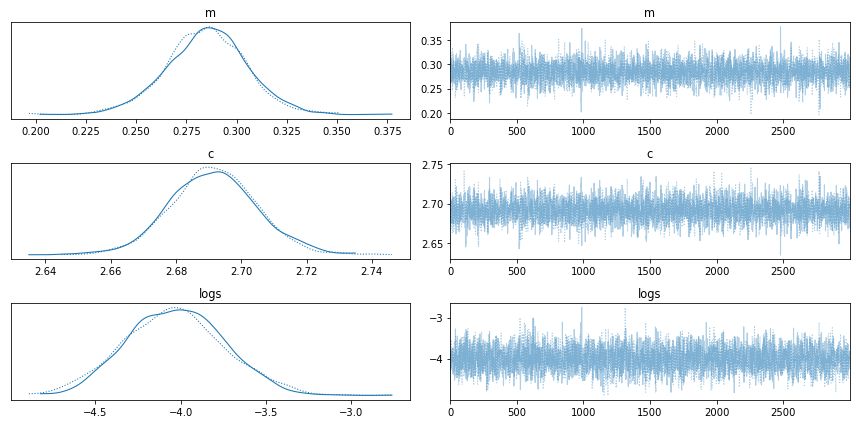

In [4]:
_ = az.plot_trace(trace, var_names=['m', 'c', 'logs'])
plt.tight_layout()

In [5]:
az.summary(trace, var_names=['m', 'c', 'logs'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
m,0.285,0.020,0.247,0.324,0.000,0.000,3580.0,3074.0,1.0
c,2.691,0.013,2.667,2.718,0.000,0.000,3705.0,3042.0,1.0
logs,-4.031,0.288,-4.560,-3.486,0.005,0.004,3147.0,2332.0,1.0


Looks like we hit the convergence! Because the Gelmann-Rubic statistic is basically 1.

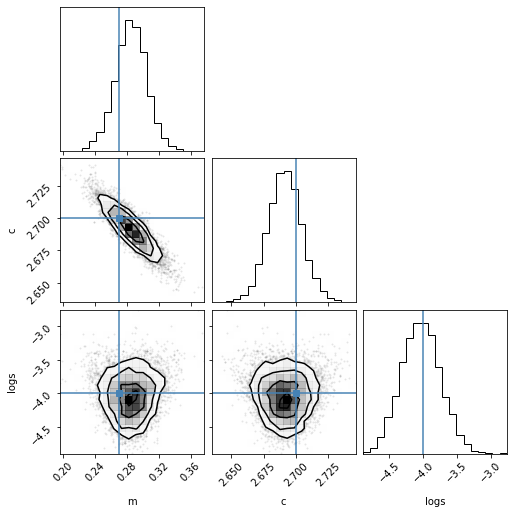

In [6]:
truth = dict(zip(['m', 'c', 'logs'], np.array([0.27, 2.7, -4]),))

_ = corner.corner(trace, var_names=['m', 'c', 'logs'], truths=truth,);

Let's see how we did!

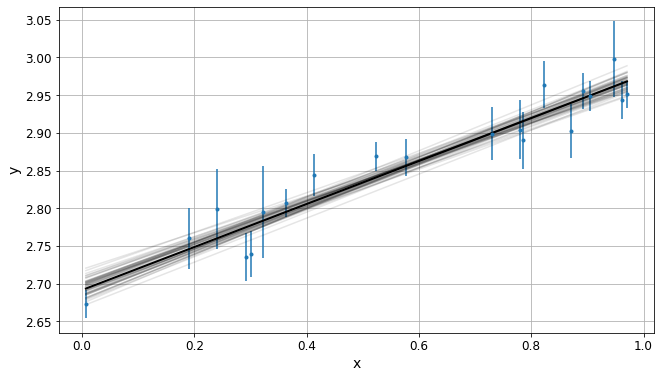

In [7]:
# Defining posteriors for each variable
m1 = np.array(trace.posterior['m']).flatten()
c1 = np.array(trace.posterior['c']).flatten()
ls1 = np.array(trace.posterior['logs']).flatten()
y1 = np.array(trace.posterior['y']).reshape(6000, 20)

fig, axs = plt.subplots(figsize=(16/1.5, 9/1.5))
axs.errorbar(x, y, yerr=np.sqrt(ye**2 + np.exp(np.median(ls1))**2), fmt='.')
axs.plot(x, np.median(m1)*x + np.median(c1), 'k-', lw=2.)
for i in range(50):
    axs.plot(x, y1[np.random.choice(np.arange(6000), replace=False),:], 'k-', alpha=0.1)
axs.set_xlabel('x', fontsize=14)
axs.set_ylabel('y', fontsize=14)
plt.setp(axs.get_xticklabels(), fontsize=12)
plt.setp(axs.get_yticklabels(), fontsize=12)
plt.grid()

Good!